# Using xrt_teem to analyze XRT data

This example demonstrates how to use xrt_teem to calculate the temperature and emission measure in an image using the filter ratio method.

First need to load packages to read in the data

In [1]:
from astropy.io import fits

from xrtpy.response.xrt_teem import xrt_teem

As an example we will use the test data included in XRTpy, though data with the right characteristics in the XRT archive could also be used. It's necessary to use two images that are the same size and use different filters. To get good results the images should have been taken close in time as well, ideally adjacent in time. Note that not all filter ratios produce good results. 

This data was generated using the IDL routine xrt_prep.pro from SolarSoft and is unnormalized. Data in the Level 1 archive are normalized, which is also okay to use, though the IDL routine xrt_teem.pro did not allow that. For normalized data the image data is multiplied by the exposure time before analysis. 

In [2]:
import pkg_resources
import sunpy.map

from pathlib import Path

directory = pkg_resources.resource_filename(
    "xrtpy", "response/tests/data/xrt_teem_testing_files"
)
data_files = sorted(Path(directory).glob("L1_XRT20110128_*.*.fits"))
file1 = data_files[1]
file2 = data_files[0]

xrt_teem uses SunPy maps as input. 

In [3]:
map1 = sunpy.map.Map(file1)
map2 = sunpy.map.Map(file2)

xrt_teem has several options, mirroring the IDL routine in SolarSoft in most respects. A simple call with no extra parameters calculates the temperature and (volume) emission measure for the two images without any binning or masking of the data.

In [4]:
Te, EM, Terr, EMerr = xrt_teem(map1, map2)

Te is the electron temperature, EM is the volume emission measure, Terr is a measure of the error in the temperature determined for each pixel and EMerr is the same for the emission measure. To examine the results one can use matplotlib and sunpy:

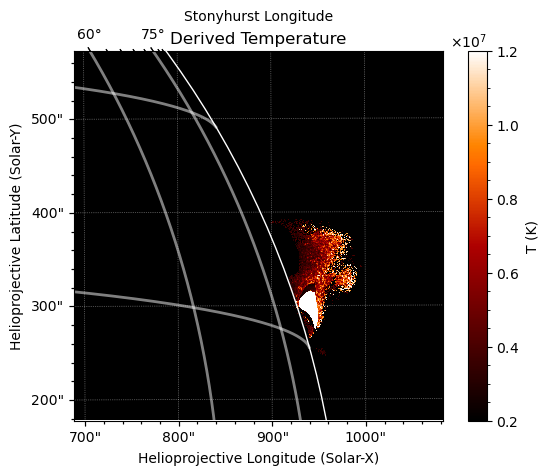

In [6]:
import matplotlib.pyplot as plt
import numpy as np

from sunpy.coordinates.sun import angular_radius, B0
from sunpy.map import Map

# To avoid error messages from sunpy we add metadata to the header:
rsun_ref = 6.95700e08
hdr1 = map1.meta
rsun_obs = angular_radius(hdr1["DATE_OBS"]).value
dsun = rsun_ref / np.sin(rsun_obs * np.pi / 6.48e5)
solarb0 = B0(hdr1["DATE_OBS"]).value
hdr1["DSUN_OBS"] = dsun
hdr1["RSUN_REF"] = rsun_ref
hdr1["RSUN_OBS"] = rsun_obs
hdr1["SOLAR_B0"] = solarb0

fig = plt.figure()
m = Map((10.0**Te, hdr1))
m.plot(title="Derived Temperature", vmin=2.0e6, vmax=1.2e7)
m.draw_limb()
m.draw_grid(linewidth=2)
cb = plt.colorbar(label="T (K)")

See the xrt_teem.py code for more information. Among the options are verbose output, binning the data by an integer factor (to increase the signal to noise), specifying a temperature range to examine, providing a mask for excluding regions of the images from the analysis, and setting error thresholds on the temperature and photon noise that differ from the default values.

These data were analyzed by Guidoni et al. (2015, ApJ 800, 54). See also Narukage et al. (2014, Solar Phys. 289, 1029). The filters for these two images are Ti poly and Be thin. 